<a href="https://colab.research.google.com/github/Mavisinrain/Fake-News-Detection/blob/main/doanma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from keras.layers import Dropout
!pip install tensorflow

In [ ]:
import tensorflow
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Tiền Xử Lý dữ liệu

In [ ]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

#Read data
fake = pd.read_csv("/content/drive/MyDrive/filedoan/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/filedoan/True.csv")

Mounted at /content/drive


In [ ]:
print(fake.shape, true.shape)

(23481, 4) (21417, 4)


In [ ]:
true.shape

(21417, 4)

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


# Đọc dữ liệu và chuẩn bị dữ liệu

In [ ]:
# Add flag to track fake and real
fake['target'] = 0
true['target'] = 1

In [ ]:
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
# # Concatenate dataframes
# data = pd.concat([fake, true]).reset_index(drop = True)
# data.shape

# Concatenate dataframes
data_a = pd.concat([fake, true]).reset_index(drop = True)
data = data_a.sample(n=5000, random_state=42)
data.shape

(5000, 5)

In [ ]:
data.head()

,title,text,subject,date,target
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 22216 to 2826
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5000 non-null   object
 1   text     5000 non-null   object
 2   subject  5000 non-null   object
 3   date     5000 non-null   object
 4   target   5000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 234.4+ KB


In [ ]:
data.describe()

,target
count,5000.000000
mean,0.470000
std,0.499149
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,title,text,subject,date,target
0,Muhammad Ali’s Son Detained At Airport Becaus...,Immigration officials in Florida proved how ou...,News,"February 25, 2017",0
1,Navy SEAL Tells Katy Perry: “Go to H*ll” [Video],Navy SEAL Carl Higbie had three words for Katy...,politics,"May 26, 2017",0
2,New Batman Comic Features Batman Saving Black ...,Full frontal Leftist propaganda As a side note...,left-news,"Nov 30, 2015",0
3,PELOSI UNHINGED: GOP Tax Reform Bill Is ‘Braze...,"Yes, keeping the money you earned is brazen t...",politics,"Dec 19, 2017",0
4,WOW! “We Mexicans Need To Kill Donald Trump Be...,And now a message of peace and unity from one ...,politics,"Sep 8, 2016",0


In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Muhammad Ali’s Son Detained At Airport Becaus...,Immigration officials in Florida proved how ou...,News,0
1,Navy SEAL Tells Katy Perry: “Go to H*ll” [Video],Navy SEAL Carl Higbie had three words for Katy...,politics,0
2,New Batman Comic Features Batman Saving Black ...,Full frontal Leftist propaganda As a side note...,left-news,0
3,PELOSI UNHINGED: GOP Tax Reform Bill Is ‘Braze...,"Yes, keeping the money you earned is brazen t...",politics,0
4,WOW! “We Mexicans Need To Kill Donald Trump Be...,And now a message of peace and unity from one ...,politics,0


In [ ]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Immigration officials in Florida proved how ou...,News,0
1,Navy SEAL Carl Higbie had three words for Katy...,politics,0
2,Full frontal Leftist propaganda As a side note...,left-news,0
3,"Yes, keeping the money you earned is brazen t...",politics,0
4,And now a message of peace and unity from one ...,politics,0


In [ ]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,immigration officials in florida proved how ou...,News,0
1,navy seal carl higbie had three words for katy...,politics,0
2,full frontal leftist propaganda as a side note...,left-news,0
3,"yes, keeping the money you earned is brazen t...",politics,0
4,and now a message of peace and unity from one ...,politics,0


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    #print(all_list)
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [ ]:
# Check
data.head()

,text,subject,target
0,immigration officials in florida proved how ou...,News,0
1,navy seal carl higbie had three words for katy...,politics,0
2,full frontal leftist propaganda as a side note...,left-news,0
3,yes keeping the money you earned is brazen th...,politics,0
4,and now a message of peace and unity from one ...,politics,0


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,text,subject,target
0,immigration officials florida proved control t...,News,0
1,navy seal carl higbie three words katy perry g...,politics,0
2,full frontal leftist propaganda side note writ...,left-news,0
3,yes keeping money earned brazen theft big gove...,politics,0
4,message peace unity one neighbors south mexica...,politics,0


# Khám Phá Dữ liệu

subject
Government News     182
Middle-east          76
News               1049
US_News              89
left-news           504
politics            750
politicsNews       1250
worldnews          1100
Name: text, dtype: int64


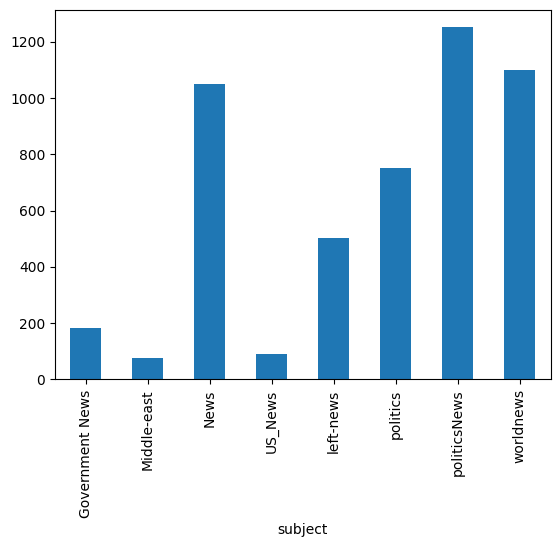

In [ ]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")

# Import the matplotlib.pyplot module and assign it to the alias 'plt'
import matplotlib.pyplot as plt
plt.show()

target
0    2650
1    2350
Name: text, dtype: int64


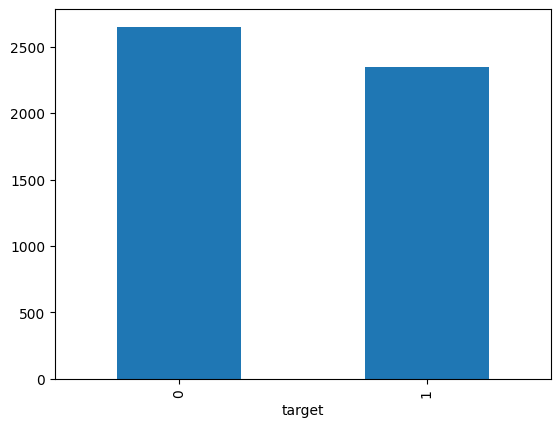

In [ ]:
  # How many fake and real articles?
  print(data.groupby(['target'])['text'].count())
  data.groupby(['target'])['text'].count().plot(kind="bar")
  plt.show()

In [ ]:
print('Tổng số quan sát : {}\n'.format(len(data)))
print('Số tin tức đúng : {}%\n'.format(
    round((len(data[data['target']==1])/len(data))*100, 2)))
print('Số tin tức giả : {}%'.format(
    round((len(data[data['target']==0])/len(data))*100, 2)))

Tổng số quan sát : 5000

Số tin tức đúng : 47.0%

Số tin tức giả : 53.0%


In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


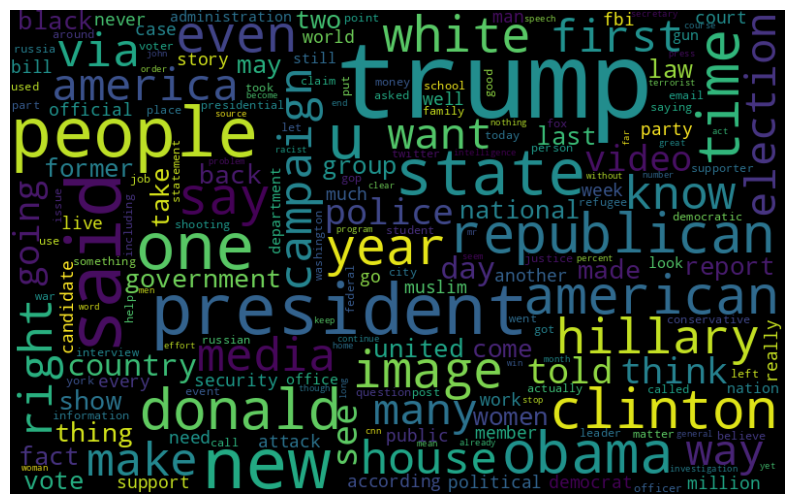

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == 0]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

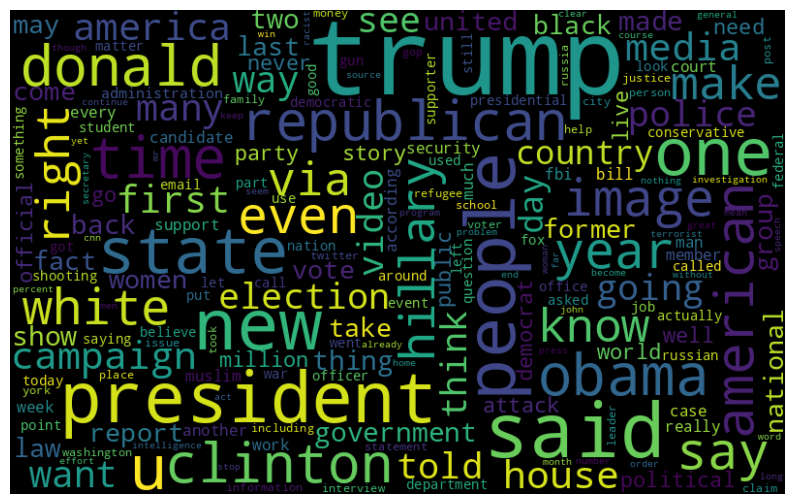

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == 1]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

In [ ]:
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

In [ ]:
# Most frequent words counter
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

import seaborn as sns # import the seaborn library

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

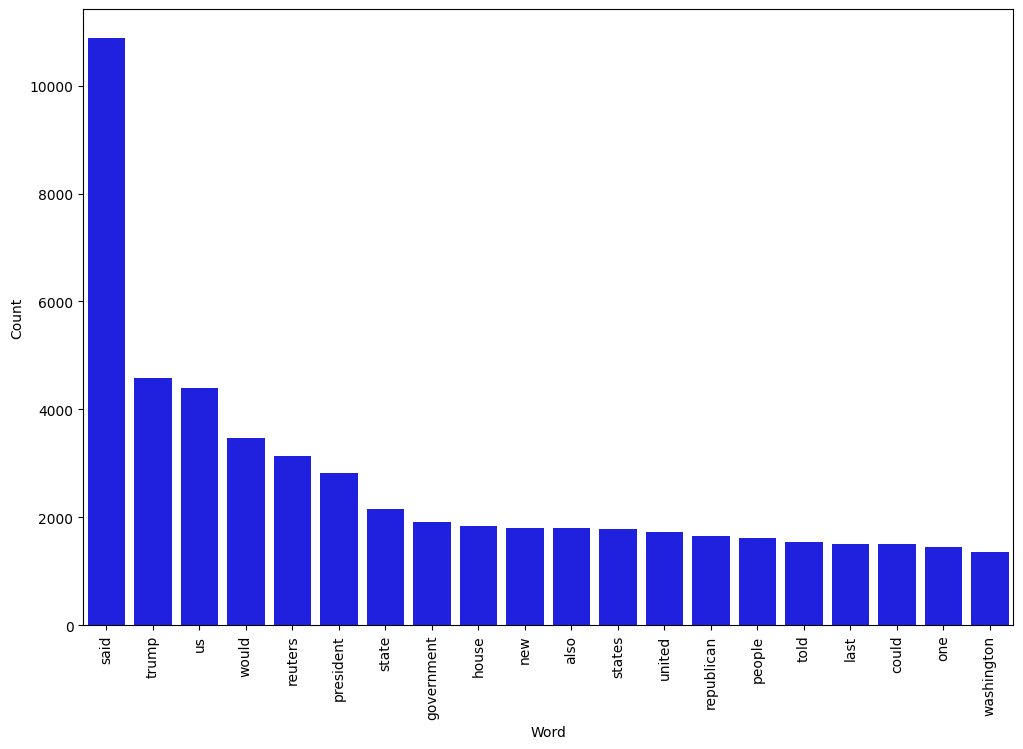

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == 1], "text", 20)

In [ ]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Split the data
from sklearn.model_selection import train_test_split # import the function from the correct module

X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(4000,)

In [ ]:
y_train.shape

(4000,)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # Mount Google Drive

# Split the data
from sklearn.model_selection import train_test_split # import the function from the correct module

X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# ... (rest of your code)

X_train.to_csv("/content/gdrive/MyDrive/filedoan/X_train.csv", index=False)
y_train.to_csv("/content/gdrive/MyDrive/filedoan/y_train.csv", index=False)

Mounted at /content/gdrive


In [ ]:
X_test.to_csv("/content/gdrive/MyDrive/filedoan/X_test.csv", index=None)
y_test.to_csv("/content/gdrive/MyDrive/filedoan/y_test.csv", index=None)

In [ ]:
print(X_train.shape, X_test.shape)

(4000,) (1000,)


In [ ]:
from sklearn.pipeline import Pipeline # import Pipeline from sklearn.pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

pipe_Data = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer())])

In [ ]:
Xtrain = pipe_Data.fit_transform(X_train)
Xtest = pipe_Data.transform(X_test)

In [ ]:
print(type(Xtrain))

<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
from scipy import sparse

In [ ]:
sparse.save_npz("X_trainV2.csv", Xtrain)

In [ ]:
sparse.save_npz("X_testV2.csv", Xtest)

In [ ]:
print(Xtrain.shape, Xtest.shape)

(4000, 59291) (1000, 59291)


In [ ]:
y_train.to_csv("/content/gdrive/MyDrive/filedoan/y_train.csv", index=False)
y_test.to_csv("/content/gdrive/MyDrive/filedoan/y_testV2.csv", index=None)

In [ ]:
def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

In [ ]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

# 1.Naive Bayes

In [ ]:
dct = dict()

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score # import the function accuracy_score from sklearn.metrics
print(X_test.shape)
NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)


(1000,)
accuracy: 94.7%


Confusion matrix, without normalization


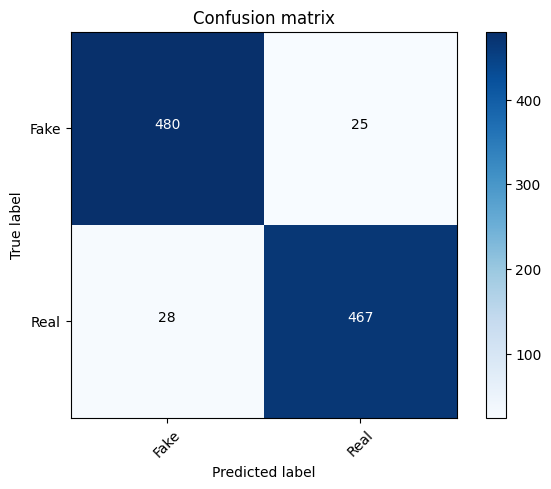

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
import time
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

dct = dict()

# Naive Bayes
NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

# Đo thời gian huấn luyện
start_time = time.time()
model = pipe.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Naive Bayes training time: {training_time:.2f} seconds")

# Dự đoán và đánh giá
prediction = model.predict(X_test)
accuracy = round(accuracy_score(y_test, prediction) * 100, 2)
dct['Naive Bayes'] = accuracy

print(f"Accuracy: {accuracy}%")

Naive Bayes training time: 1.53 seconds
Accuracy: 94.7%


# 2.Logistic regression

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 97.7%


In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Đo thời gian huấn luyện
start_time = time.time()
model = pipe.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Logistic Regression training time: {training_time:.2f} seconds")

# Dự đoán và đánh giá
prediction = model.predict(X_test)
accuracy = round(accuracy_score(y_test, prediction) * 100, 2)
dct['Logistic Regression'] = accuracy

print(f"Accuracy: {accuracy}%")

Logistic Regression training time: 2.46 seconds
Accuracy: 97.7%


Confusion matrix, without normalization


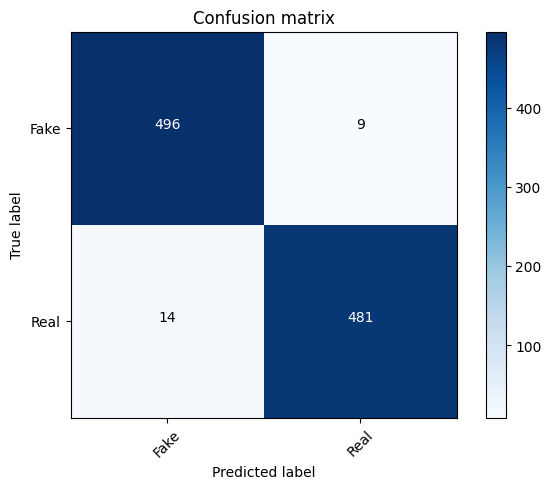

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# 3.Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.5%


In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42))])

# Đo thời gian huấn luyện
start_time = time.time()
model = pipe.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Decision Tree training time: {training_time:.2f} seconds")

# Dự đoán và đánh giá
prediction = model.predict(X_test)
accuracy = round(accuracy_score(y_test, prediction) * 100, 2)
dct['Decision Tree'] = accuracy

print(f"Accuracy: {accuracy}%")

Decision Tree training time: 1.83 seconds
Accuracy: 99.5%


Confusion matrix, without normalization


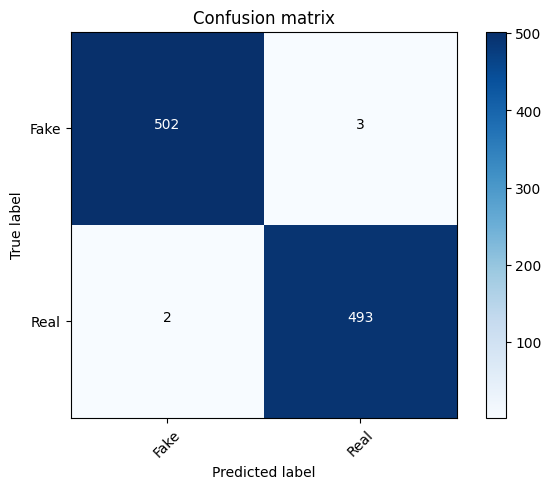

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# 4.Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 97.9%


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

# Đo thời gian huấn luyện
start_time = time.time()
model = pipe.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Random Forest training time: {training_time:.2f} seconds")

# Dự đoán và đánh giá
prediction = model.predict(X_test)
accuracy = round(accuracy_score(y_test, prediction) * 100, 2)
dct['Random Forest'] = accuracy

print(f"Accuracy: {accuracy}%")

Random Forest training time: 3.78 seconds
Accuracy: 97.3%


Confusion matrix, without normalization


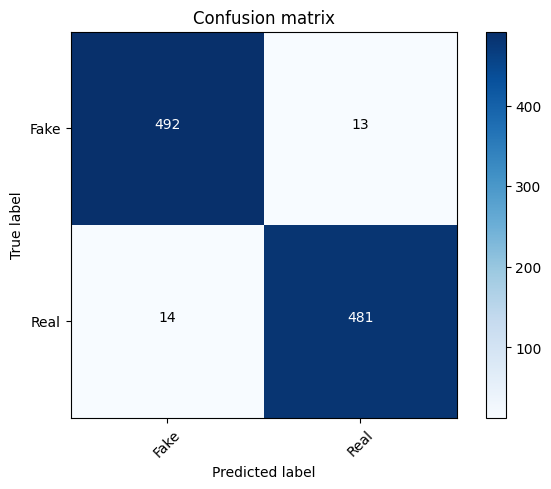

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=40, stop=400, num=15)]
max_depth = [int(x) for x in np.linspace(2, 150, num=15)]

In [ ]:
param_dist = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
}

In [ ]:
ran_for = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    estimator=ran_for, param_distributions=param_dist, cv=5, random_state=42)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf_cv.fit(Xtrain, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [2, 12, 23, 33, 44, 54, 65,
                                                      76, 86, 97, 107, 118, 128,
                                                      139, 150],
                                        'n_estimators': [40, 65, 91, 117, 142,
                                                         168, 194, 220, 245,
                                                         271, 297, 322, 348,
                                                         374, 400]},
                   random_state=42)

In [ ]:
rf_cv.best_params_

{'n_estimators': 374, 'max_depth': 118}

In [ ]:
rf_best = RandomForestClassifier(max_depth=97, n_estimators=374, random_state=42)

In [ ]:
model = rf_best.fit(Xtrain, y_train)

In [ ]:
prediction = model.predict(Xtest)

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['RF_Tuning'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.4%


# 5.SVM

In [ ]:
from sklearn import svm

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


# Create an empty dictionary to store the accuracy scores
dct = {}

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

# Store the accuracy score in the dictionary
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 97.9%


In [ ]:
# SVM
from sklearn import svm

clf = svm.SVC(kernel='linear')  # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

# Đo thời gian huấn luyện
start_time = time.time()
model = pipe.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"SVM training time: {training_time:.2f} seconds")

# Dự đoán và đánh giá
prediction = model.predict(X_test)
accuracy = round(accuracy_score(y_test, prediction) * 100, 2)
dct['SVM'] = accuracy

print(f"Accuracy: {accuracy}%")

SVM training time: 14.02 seconds
Accuracy: 97.9%


Confusion matrix, without normalization


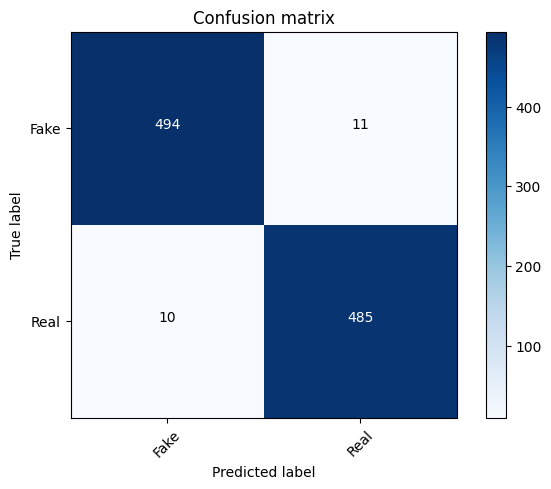

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# 6. DNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.5701 - loss: 0.6855 - val_accuracy: 0.9000 - val_loss: 0.5897
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9542 - loss: 0.4495 - val_accuracy: 0.9625 - val_loss: 0.1639
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.9859 - loss: 0.0804 - val_accuracy: 0.9650 - val_loss: 0.0815
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9959 - loss: 0.0222 - val_accuracy: 0.9750 - val_loss: 0.0669
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9750 - val_loss: 0.0587
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9825 - val_loss: 0.0559
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9825 - val_loss: 0.0553
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9996 - loss: 0.0011 - 

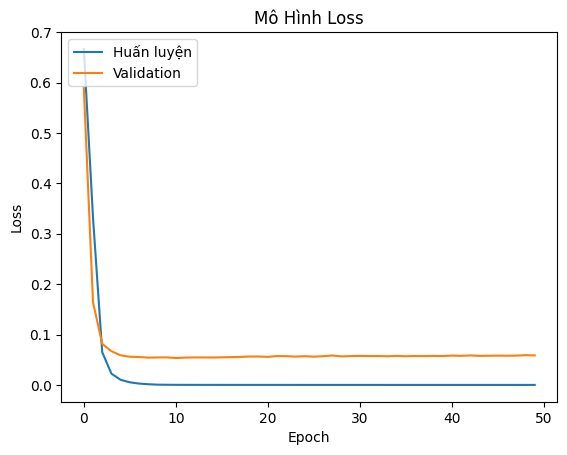

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Định nghĩa Pipeline cho vector hóa và TF-IDF
pipe_Data = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

# Định nghĩa mô hình DNN


model = Sequential([
    Dense(128, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Biên dịch mô hình
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
# Biên dịch mô hình
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit(Xtrain, y_train, epochs=50, batch_size=16, validation_split=0.1)
# Vẽ biểu đồ loss cho quá trình huấn luyện và validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mô Hình Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Huấn luyện', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

In [ ]:
print(X_test.shape)
pipe_Data.fit(X_train)
Xtrain = pipe_Data.transform(X_train)
Xtest = pipe_Data.transform(X_test)
Xtest = Xtest.toarray()
prediction_dnn = model.predict(Xtest)
prediction_binary = (prediction_dnn > 0.5).astype(int)
print("Accuracy score: {:.2f}".format(accuracy_score(y_test, prediction_binary)))

In [ ]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# Định nghĩa Pipeline cho vector hóa và TF-IDF
pipe_Data = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer())])

pipe_Data.fit(X_train)
Xtrain = pipe_Data.transform(X_train)
Xtest = pipe_Data.transform(X_test)

Xtest = Xtest.toarray()

# Định nghĩa mô hình DNN
model = Sequential([
    Dense(128, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])

# Đo thời gian huấn luyện
start_time = time.time()
history = model.fit(Xtrain, y_train, epochs=50, batch_size=16, validation_split=0.1)
end_time = time.time()

training_time = end_time - start_time
print(f"DNN training time: {training_time:.2f} seconds")

# Dự đoán và đánh giá
prediction_dnn = model.predict(Xtest)
prediction_binary = (prediction_dnn > 0.5).astype(int)

accuracy = accuracy_score(y_test, prediction_binary)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
dct['Naive Bayes Time'] = round(training_time, 2)
dct['Logistic Regression Time'] = round(training_time, 2)
dct['Decision Tree Time'] = round(training_time, 2)
dct['Random Forest Time'] = round(training_time, 2)
dct['SVM Time'] = round(training_time, 2)
dct['DNN Time'] = round(training_time, 2)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử bạn đã có từ điển dct chứa thời gian huấn luyện của các mô hình
dct = {
    'Naive Bayes Time': 2.14,
    'Logistic Regression Time': 2.81,
    'Decision Tree Time': 7.92,
    'Random Forest Time': 4.95,
    'SVM Time': 17.54,
    'DNN Time': 1159.07
}

# Chuyển từ điển dct thành DataFrame
time_df = pd.DataFrame(list(dct.items()), columns=['Model', 'Training Time (seconds)'])

# Vẽ biểu đồ cột (bar chart)
plt.figure(figsize=(10, 6))  # Tăng kích thước của biểu đồ
bars = plt.barh(time_df['Model'], time_df['Training Time (seconds)'], color='skyblue', height=0.8)  # Tăng độ dày cột

# Thêm số thời gian lên mỗi cột kèm theo chữ "s"
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,  # Vị trí của số (x, y)
             f'{bar.get_width():.2f} s',  # Số thời gian với chữ "s" ở cuối
             va='center', ha='left', fontsize=12, color='black')  # Tùy chỉnh văn bản

# Thêm tiêu đề và nhãn cho trục
plt.title('Comparison of Training Time for Different Models', fontsize=16)  # Tăng cỡ chữ tiêu đề
plt.xlabel('Training Time (seconds)', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Hiển thị biểu đồ
plt.show()

# IN KET QUA RANDOM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

random_index = random.choice(range(len(X_test)))  # Chọn chỉ số ngẫu nhiên trong X_test

# Lấy mẫu dữ liệu tương ứng từ X_test, using Xtest instead of X_test_transformed
data_point = Xtest[random_index]  # Dữ liệu mẫu ngẫu nhiên
nb = MultinomialNB()

# Fit the MultinomialNB model before making predictions
nb.fit(Xtrain, y_train) # Assuming Xtrain and y_train are your training data

# Dự đoán bằng Naive Bayes
prediction_nb = nb.predict(data_point.reshape(1, -1))
# Dự đoán bằng Logistic regression
lr = LogisticRegression() # Create an instance of LogisticRegression
lr.fit(Xtrain, y_train) # Train the model using your training data
# Reshape data_point to a 2D array before prediction
prediction_lr = lr.predict(data_point.reshape(1, -1))
# Dự đoán bằng Decision Tree
dt = DecisionTreeClassifier() # Create an instance of DecisionTreeClassifier
dt.fit(Xtrain, y_train) # Train the model using your training data
prediction_dt = dt.predict(data_point.reshape(1, -1)) # Assuming 'dt' is your Decision Tree model
# Dự đoán bằng Random Forest
rf = RandomForestClassifier() # Create an instance of RandomForestClassifier
rf.fit(Xtrain, y_train) # Fit the model to your training data
prediction_rf = rf.predict(data_point.reshape(1, -1)) # Assuming 'rf' is your Random Forest model
# Dự đoán bằng Support Vector Machine (SVM)
svm = SVC() # Create an instance of the SVC classifier
svm.fit(Xtrain, y_train) # Fit the SVM model to your training data
prediction_svm = svm.predict(data_point.reshape(1, -1)) # Assuming 'svm' is your SVM model
# Dự đoán bằng Deep Neural Network (DNN)
prediction_dnn = model.predict(data_point.reshape(1, -1))  # reshape để có đúng dạng đầu vào cho model

# Chuyển đổi dự đoán thành giá trị nhị phân (0 hoặc 1)
prediction_dnn_binary = 1 if prediction_dnn > 0.5 else 0

# In ra chỉ số ngẫu nhiên và kết quả dự đoán
print(f"Chỉ số ngẫu nhiên chọn: {random_index}")
print("Kết quả dự đoán bằng Deep Neural Network (DNN):", prediction_dnn_binary)
print("Kết quả dự đoán bằng Naive Bayes:", prediction_nb)
print("Kết quả dự đoán bằng Logistic Regression:", prediction_lr)
print("Kết quả dự đoán bằng Decision Tree:", prediction_dt)
print("Kết quả dự đoán bằng SVM:", prediction_svm)
print("Kết quả dự đoán bằng Random Forest:", prediction_rf)
label_random_index = y_test.iloc[random_index]  # Nếu y_train là DataFrame hoặc Series
print(f"Label của chỉ số {random_index} là: {label_random_index}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# Define the algorithms and their corresponding accuracy scores
algorithms = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Deep Neural Network (DNN)']
# Predict on the entire Xtest dataset for all models
prediction_nb = nb.predict(Xtest)
prediction_lr = lr.predict(Xtest)
prediction_dt = dt.predict(Xtest)
prediction_rf = rf.predict(Xtest)
prediction_svm = svm.predict(Xtest)
# Define scores for each algorithm. Replace with actual accuracy scores.
scores = [
    accuracy_score(y_test, prediction_nb),  # Assuming 'prediction_nb' is the prediction for Naive Bayes
    accuracy_score(y_test, prediction_lr),  # Assuming 'prediction_lr' is the prediction for Logistic Regression
    accuracy_score(y_test, prediction_dt),  # Assuming 'prediction_dt' is the prediction for Decision Tree
    accuracy_score(y_test, prediction_rf),  # Assuming 'prediction_rf' is the prediction for Random Forest
    accuracy_score(y_test, prediction_svm), # Assuming 'prediction_svm' is the prediction for SVM
    accuracy_score(y_test, prediction_binary)  # Assuming 'prediction_binary' is the prediction for DNN
]


# Vẽ biểu đồ sử dụng seaborn
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy Score (%)")

# Chuyển đổi điểm số thành phần trăm
scores_percentage = [score * 100 for score in scores] # Multiply by 100 to get percentage

# Vẽ biểu đồ
sns.barplot(x=algorithms, y=scores_percentage, palette="viridis")
plt.xticks(rotation=45)  # Xoay nhãn thuật toán nếu cần
plt.title("Accuracy Score by Algorithm")

# Hiển thị điểm số trên từng thanh
for index, value in enumerate(scores_percentage):
    plt.text(index, value + 0.5, f'{value:.2f} %', ha='center')

plt.show()

In [ ]:
print("Accuracy of each model:")
for model_name, accuracy in dct.items():
    print(f"{model_name}: {accuracy}%")

# 8. Vẽ biểu đồ so sánh Accuracy của các mô hình
models = list(dct.keys())
accuracy_values = list(dct.values())

plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Models')

# Hiển thị giá trị độ chính xác trên các thanh cột
for i, v in enumerate(accuracy_values):
    plt.text(v + 1, i, f"{v}%", va='center', color='black')

plt.show()